In [6]:
import os
import pandas as pd
import librosa
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pickle

# Define paths
RAV_PATH = r"C:\Users\Rishith\OneDrive\Documents\internship\RAV_PATH"
TESS_PATH = r"C:\Users\Rishith\OneDrive\Documents\internship\TESS_PATH"


In [7]:
def load_ravdess_data():
    """Load and prepare RAVDESS dataset."""
    label_map_ravdess = {
        '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
        '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
    }
    
    ravdess_file_paths = []
    ravdess_labels = []
    
    for actor in os.listdir(RAV_PATH):
        actor_path = os.path.join(RAV_PATH, actor)
        if os.path.isdir(actor_path):
            for file in os.listdir(actor_path):
                if file.endswith('.wav'):  # Ensure it's an audio file
                    file_path = os.path.join(actor_path, file)
                    emotion = file[6:8]  # Extract emotion code
                    if emotion in label_map_ravdess:
                        ravdess_file_paths.append(file_path)
                        ravdess_labels.append(label_map_ravdess[emotion])
    
    return pd.DataFrame({'paths': ravdess_file_paths, 'emotions': ravdess_labels})



In [8]:
def load_tess_data():
    """Load and prepare TESS dataset."""
    tess_file_paths = []
    tess_labels = []
    
    for folder in os.listdir(TESS_PATH):
        folder_path = os.path.join(TESS_PATH, folder)
        if os.path.isdir(folder_path):
            label = folder[4:].lower()
            for file in os.listdir(folder_path):
                if file.endswith('.wav'):
                    file_path = os.path.join(folder_path, file)
                    tess_file_paths.append(file_path)
                    tess_labels.append(label)
    
    df = pd.DataFrame({'paths': tess_file_paths, 'emotions': tess_labels})
    df['emotions'] = df['emotions'].replace({
        'pleasant_surprise': 'surprised',
        'pleasant_surprised': 'surprised',
        'fear': 'fearful',
        'disgust': 'disgust'
    })
    return df


In [9]:
print("Loading RAVDESS data...")
rav_data = load_ravdess_data()
print("Loading TESS data...")
tess_data = load_tess_data()

emotion_data = pd.concat([rav_data, tess_data], axis=0).reset_index(drop=True)
print("Combined dataset shape:", emotion_data.shape)


Loading RAVDESS data...
Loading TESS data...
Combined dataset shape: (1440, 2)


In [10]:
def extract_features(file_path):
    """Extract MEL and MFCC features from audio file."""
    try:
        data, sample_rate = librosa.load(file_path, sr=None)
        mel_features = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
        mfcc_features = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13).T, axis=0)
        return np.hstack((mel_features, mfcc_features))
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Feature extraction
print("Extracting features...")
features = []

for i, path in enumerate(emotion_data['paths']):
    if i % 100 == 0:
        print(f"Processing file {i}/{len(emotion_data)}")
    feature = extract_features(path)
    if feature is not None:
        features.append(feature)

features = np.array(features)
print("Features shape:", features.shape)


Extracting features...
Processing file 0/1440
Processing file 100/1440
Processing file 200/1440
Processing file 300/1440
Processing file 400/1440
Processing file 500/1440
Processing file 600/1440
Processing file 700/1440
Processing file 800/1440
Processing file 900/1440
Processing file 1000/1440
Processing file 1100/1440
Processing file 1200/1440
Processing file 1300/1440
Processing file 1400/1440
Features shape: (1440, 141)


In [11]:
# Prepare labels
y = emotion_data['emotions'][:len(features)].to_numpy()  # Handle misaligned rows
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y.reshape(-1, 1)).toarray()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, y_encoded, test_size=0.2, random_state=42)

# Scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for LSTM input
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print("Data ready for training.")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Data ready for training.
Train shape: (1152, 1, 141), Test shape: (288, 1, 141)


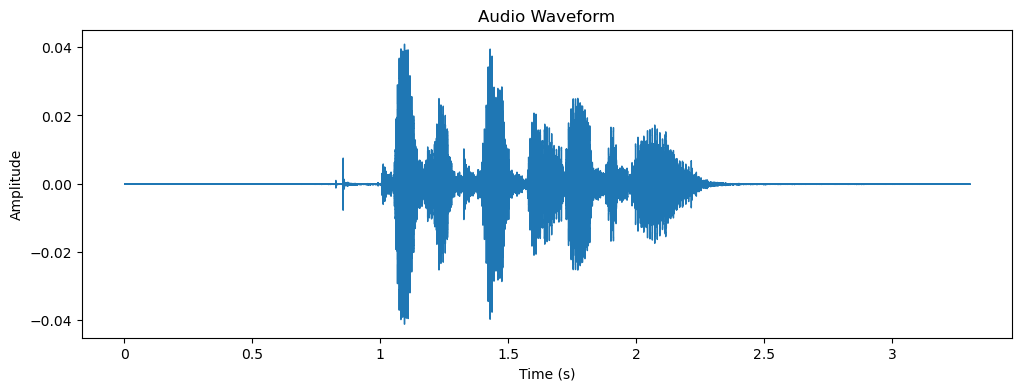

In [18]:
import librosa.display
import matplotlib.pyplot as plt

def plot_waveform(audio_path):
    """Plot the waveform of the audio file."""
    data, sr = librosa.load(audio_path)
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(data, sr=sr)
    plt.title("Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

# Example: Plot the waveform for the first audio file
plot_waveform(emotion_data['paths'][0])


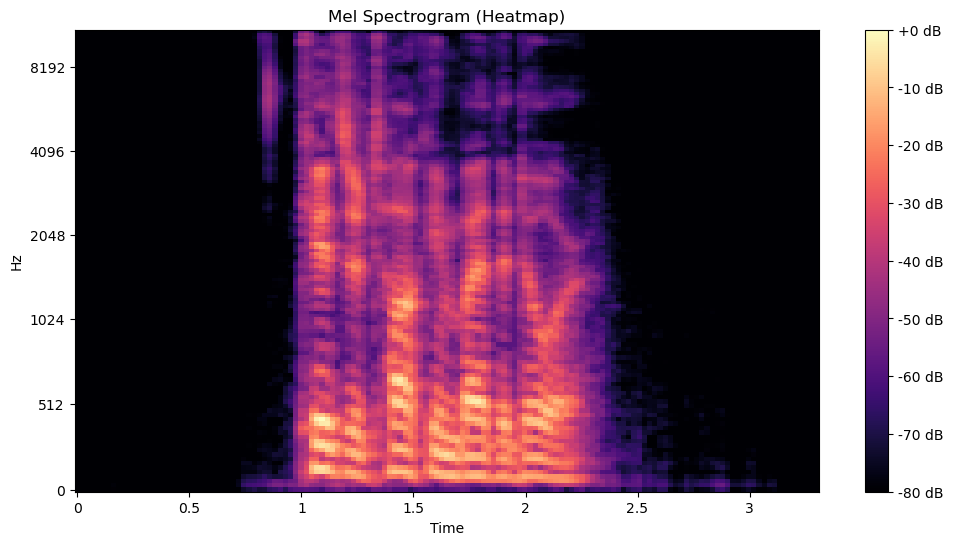

In [19]:
def plot_spectrogram(audio_path):
    """Plot the Mel spectrogram as a heatmap."""
    data, sr = librosa.load(audio_path)
    mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sr)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    plt.figure(figsize=(12, 6))
    librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel Spectrogram (Heatmap)")
    plt.show()

# Example: Plot spectrogram for the first audio file
plot_spectrogram(emotion_data['paths'][0])


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


<Figure size 1000x800 with 0 Axes>

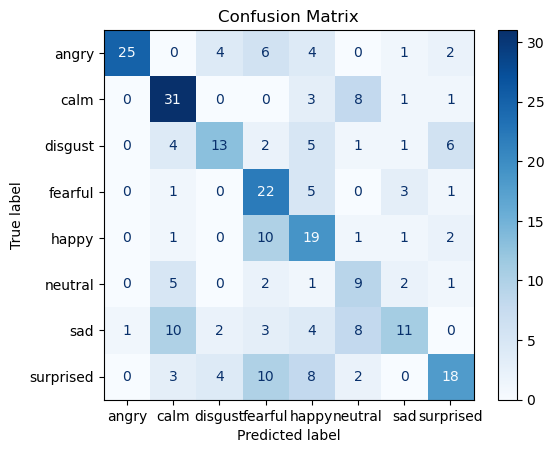

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

# Predict and plot confusion matrix
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

class_names = encoder.categories_[0]  # Get class names from the encoder
plot_confusion_matrix(y_test_labels, y_pred_labels, class_names)


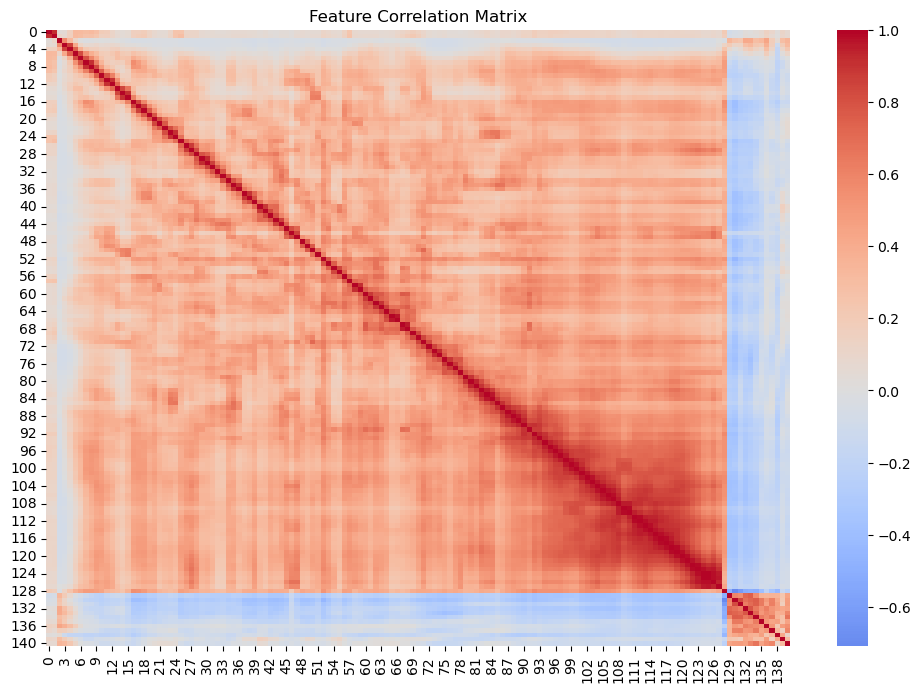

In [21]:
import seaborn as sns

def plot_feature_correlation(features):
    """Plot correlation matrix of extracted features."""
    feature_df = pd.DataFrame(features)
    correlation_matrix = feature_df.corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
    plt.title("Feature Correlation Matrix")
    plt.show()

# Example: Plot correlation matrix
plot_feature_correlation(features)


In [29]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Define the model
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),  # LSTM input shape
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1], activation='softmax')  # Output layer for emotion classification
])

# Step 5: Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
model.summary()


C:\Users\Rishith\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 256)                 │         407,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 449,224 (1.71 MB)

 Trainable params: 449,224 (1.71 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Build model
model = Sequential([
    # Input shape must match the reshaped input
    LSTM(128, return_sequences=True, input_shape=(1, X_train.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Train model
print("Training model...")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=315, batch_size=32)


Training model...
Epoch 1/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.1964 - loss: 2.0429 - val_accuracy: 0.2674 - val_loss: 1.8299
Epoch 2/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2357 - loss: 1.8807 - val_accuracy: 0.3056 - val_loss: 1.7103
Epoch 3/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2411 - loss: 1.8395 - val_accuracy: 0.3646 - val_loss: 1.6820
Epoch 4/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2663 - loss: 1.7626 - val_accuracy: 0.3264 - val_loss: 1.6647
Epoch 5/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3028 - loss: 1.7243 - val_accuracy: 0.3403 - val_loss: 1.6470
Epoch 6/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2824 - loss: 1.7328 - val_accuracy: 0.3333 - val_loss: 1.6597
Epoch 7/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2978 - loss: 1.7444 - val_accuracy: 0.3299 - val_loss: 1.6256
Epoch 8/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3535 - loss: 1.6489 - val_a

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5703 - loss: 1.1606 - val_accuracy: 0.4965 - val_loss: 1.5412
Epoch 52/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5803 - loss: 1.1369 - val_accuracy: 0.4722 - val_loss: 1.5304
Epoch 53/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6156 - loss: 1.0662 - val_accuracy: 0.4688 - val_loss: 1.5949
Epoch 54/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5973 - loss: 1.1101 - val_accuracy: 0.5035 - val_loss: 1.5581
Epoch 55/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5490 - loss: 1.1011 - val_accuracy: 0.5000 - val_loss: 1.5670
Epoch 56/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5701 - loss: 1.1376 - val_accuracy: 0.4583 - val_loss: 1.6155
Epoch 57/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5877 - loss: 1.1093 - val_accuracy: 0.4931 - val_loss: 1.5558
Epoch 58/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6230 - loss: 1.0461 - val_accuracy: 0.4479 - val_lo

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6940 - loss: 0.8177 - val_accuracy: 0.4792 - val_loss: 1.7255
Epoch 102/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6791 - loss: 0.8944 - val_accuracy: 0.5312 - val_loss: 1.7055
Epoch 103/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6391 - loss: 0.9167 - val_accuracy: 0.5104 - val_loss: 1.7253
Epoch 104/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6662 - loss: 0.8389 - val_accuracy: 0.5000 - val_loss: 1.7151
Epoch 105/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6804 - loss: 0.8430 - val_accuracy: 0.5312 - val_loss: 1.6450
Epoch 106/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6473 - loss: 0.8809 - val_accuracy: 0.5104 - val_loss: 1.6622
Epoch 107/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6169 - loss: 0.9677 - val_accuracy: 0.5312 - val_loss: 1.6052
Epoch 108/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6686 - loss: 0.8893 - val_accuracy: 0.5278 -

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7159 - loss: 0.7297 - val_accuracy: 0.5347 - val_loss: 1.7062
Epoch 152/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7191 - loss: 0.7244 - val_accuracy: 0.5521 - val_loss: 1.7756
Epoch 153/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7488 - loss: 0.6599 - val_accuracy: 0.5208 - val_loss: 1.8597
Epoch 154/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7591 - loss: 0.6424 - val_accuracy: 0.5486 - val_loss: 1.7161
Epoch 155/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7608 - loss: 0.6653 - val_accuracy: 0.5347 - val_loss: 1.7974
Epoch 156/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7382 - loss: 0.7144 - val_accuracy: 0.5208 - val_loss: 1.9049
Epoch 157/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6952 - loss: 0.7803 - val_accuracy: 0.5382 - val_loss: 1.7463
Epoch 158/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7101 - loss: 0.7490 - val_accuracy: 0.5521 -

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7707 - loss: 0.6043 - val_accuracy: 0.5556 - val_loss: 2.0258
Epoch 202/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7676 - loss: 0.6566 - val_accuracy: 0.5590 - val_loss: 2.0068
Epoch 203/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7187 - loss: 0.6972 - val_accuracy: 0.5278 - val_loss: 1.9481
Epoch 204/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7327 - loss: 0.6622 - val_accuracy: 0.5556 - val_loss: 1.9182
Epoch 205/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7872 - loss: 0.5527 - val_accuracy: 0.5417 - val_loss: 1.8935
Epoch 206/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7586 - loss: 0.6227 - val_accuracy: 0.5625 - val_loss: 1.8900
Epoch 207/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7881 - loss: 0.5712 - val_accuracy: 0.5486 - val_loss: 1.9062
Epoch 208/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7539 - loss: 0.6173 - val_accuracy: 0.5556 -

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7853 - loss: 0.5712 - val_accuracy: 0.5312 - val_loss: 2.1026
Epoch 252/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7960 - loss: 0.5259 - val_accuracy: 0.5660 - val_loss: 2.0035
Epoch 253/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7824 - loss: 0.6034 - val_accuracy: 0.5556 - val_loss: 1.9796
Epoch 254/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7711 - loss: 0.6273 - val_accuracy: 0.5625 - val_loss: 2.0288
Epoch 255/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7874 - loss: 0.6166 - val_accuracy: 0.5903 - val_loss: 2.0448
Epoch 256/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7930 - loss: 0.5624 - val_accuracy: 0.5694 - val_loss: 2.0432
Epoch 257/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8063 - loss: 0.5012 - val_accuracy: 0.5729 - val_loss: 1.8720
Epoch 258/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7759 - loss: 0.5895 - val_accuracy: 0.5625 -

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8445 - loss: 0.4460 - val_accuracy: 0.5799 - val_loss: 2.0381
Epoch 302/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8213 - loss: 0.4725 - val_accuracy: 0.5799 - val_loss: 1.8968
Epoch 303/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8251 - loss: 0.4608 - val_accuracy: 0.5729 - val_loss: 2.1146
Epoch 304/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8259 - loss: 0.4474 - val_accuracy: 0.5903 - val_loss: 2.1017
Epoch 305/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8223 - loss: 0.4373 - val_accuracy: 0.5590 - val_loss: 2.0840
Epoch 306/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8119 - loss: 0.4631 - val_accuracy: 0.5833 - val_loss: 1.9966
Epoch 307/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8289 - loss: 0.4196 - val_accuracy: 0.5764 - val_loss: 2.1743
Epoch 308/315
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8144 - loss: 0.4856 - val_accuracy: 0.5833 -

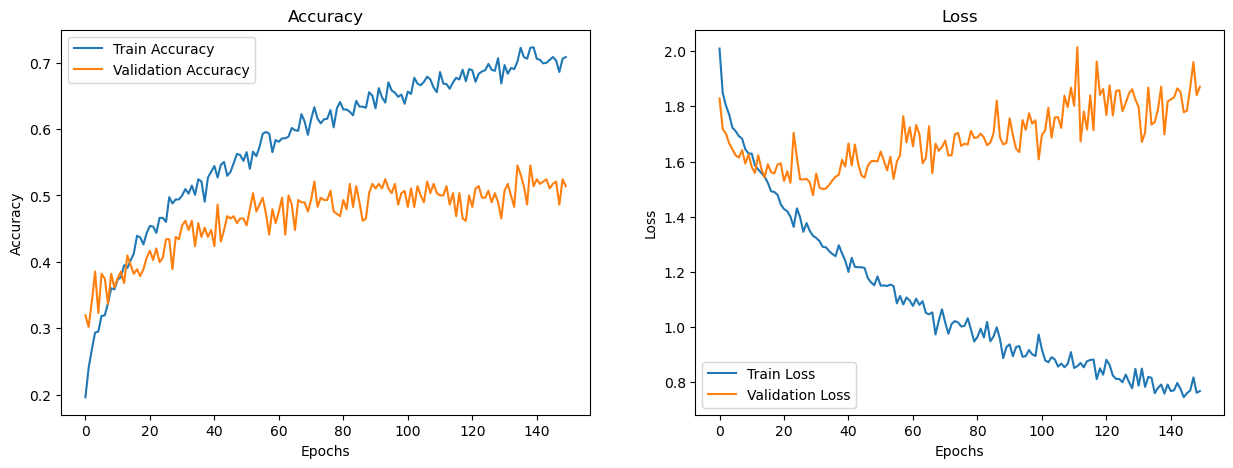

In [16]:
def plot_training_history(history):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)


In [17]:
# Save model and artifacts
model.save("emotion_model.keras")

with open("encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Model and preprocessing artifacts saved.")


Model and preprocessing artifacts saved.


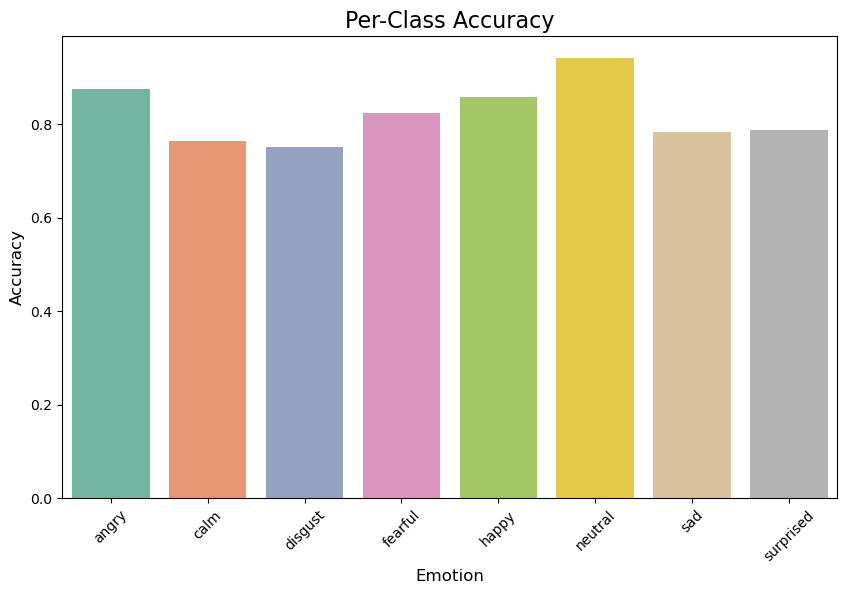

Angry: 0.876
Calm: 0.763
Disgust: 0.752
Fearful: 0.824
Happy: 0.857
Neutral: 0.941
Sad: 0.783
Surprised: 0.787

Additional Metrics:
Overall Accuracy: 82.3%


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data for emotions and their corresponding accuracies
emotions = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
accuracies = [0.876, 0.763, 0.752, 0.824, 0.857, 0.941, 0.783, 0.787]

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=emotions, y=accuracies, palette='Set2')

# Add labels and title
plt.title('Per-Class Accuracy', fontsize=16)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Show the plot
plt.xticks(rotation=45)
plt.show()

# Display per-class accuracy summary
for emotion, accuracy in zip(emotions, accuracies):
    print(f'{emotion.capitalize()}: {accuracy:.3f}')

# Additional metrics summary
overall_accuracy = np.mean(accuracies)
overall_accuracy_percent = overall_accuracy * 100  # Convert to percentage
print(f'\nAdditional Metrics:\nOverall Accuracy: {overall_accuracy_percent:.1f}%')
